# Multi-Resolution Modeling

This tutorial shows how to model sources from images observed with different telescopes. We will use a multiband observation with the Hyper-Sprime Cam (HSC) and a single high-resolution image from the Hubble Space Telescope (HST).

In [24]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Import Packages and setup
from os import listdir
from os.path import isfile, join
# Import Packages and setup
import numpy as np
import scarlet
import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from scarlet import Starlet
from scarlet.wavelet import mad_wavelet
import scipy.stats as scs
from scarlet.initialization import build_initialization_coadd
from functools import partial
import collections



%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

## Load and Display Data

We first load the HSC and HST images, swapping the byte order if necessary because a bug in astropy does not respect the local endianness.

In [4]:
#2, 5, 10, 16


# Load the HSC Cube for hsc images
image_number = "16"
path_hsc = '/Users/rahim/Desktop/repo/AGN_Deblending/Extract/data/HSC_cube/'
obs_hdu = fits.open(path_hsc + image_number +'-cube_hsc_image.fits')
data_hsc = obs_hdu[0].data.byteswap().newbyteorder()
wcs_hsc = WCS(obs_hdu[0].header)
channels_hsc = ['g','r','i','z','y']

# Load the Cube HSC PSF data 
psf_hsc = fits.open('./data/HSC_PSF_cube/' + image_number + '-cube_hsc_psf.fits')[0].data
Np1, Np2 = psf_hsc[0].shape
psf_hsc = scarlet.PSF(psf_hsc)

# Load for HST image data one band only
path_hst = '/Users/rahim/Desktop/repo/AGN_Deblending/Extract/data/HST_CUT/'
hst_hdu = fits.open(path_hst + image_number + '-hst_cut_cosmos.fits')
data_hst = hst_hdu[0].data
wcs_hst = WCS(hst_hdu[0].header)
channels_hst = ['F814W'] # F814W = name of HST band corespond to "i" band

# Load the HST PSF data 
psf_hst = fits.open('./data/HST_psfs/' + image_number + '-psf-HST-COSMOS.fits')[0].data
psf_hst = psf_hst[None,:,:]
psf_hst = scarlet.PSF(psf_hst)

# Scale the HST data
n1,n2 = np.shape(data_hst)
data_hst = data_hst.reshape(1, n1, n2).byteswap().newbyteorder()

r, N1, N2 = data_hsc.shape

In [5]:
# Modifications to the scarlet base functions and classes
def init_extended_source(
    sky_coord,
    frame,
    observations,
    coadd=None,
    bg_cutoff=None,
    thresh=1,
    symmetric=True,
    monotonic="flat",
    min_grad=0.1,
):
    """Initialize the source that is symmetric and monotonic
    See `ExtendedSource` for a description of the parameters
    """
    try:
        iter(observations)
    except TypeError:
        observations = [observations]
    # determine initial SED from peak position
    # SED in the frame for source detection
    seds = []
    for obs in observations:
        if type(obs) is scarlet.LowResObservation:
            norm = "sum"
        else:
            norm = "max"
        _sed = scarlet.get_psf_sed(sky_coord, obs, frame, normalization=norm)
        seds.append(_sed)
    sed = np.concatenate(seds).flatten()
    if np.all(sed <= 0):
        # If the flux in all channels is  <=0,
        msg = f"Zero or negative SED {sed} at y={sky_coord[0]}, x={sky_coord[1]}"
        logger.warning(msg)
    if coadd is None:
        # which observation to use for detection and morphology
        try:
            bg_rms = np.array([[1 / np.sqrt(w[w > 0].mean()) for w in obs_.weights] for obs_ in observations])
        except:
            raise AttributeError(
                "Observation.weights missing! Please set inverse variance weights"
            )
        coadd, bg_cutoff = scarlet.initialization.build_sed_coadd(seds, bg_rms, observations)
    else:
        if bg_cutoff is None:
            raise AttributeError(
                "background cutoff missing! Please set argument bg_cutoff"
            )
    # Apply the necessary constraints
    center = frame.get_pixel(sky_coord)
    if symmetric:
        morph = scarlet.operator.prox_uncentered_symmetry(
            coadd.copy(), 0, center=center, algorithm="sdss" # *1 is to artificially pass a variable that is not coadd
        )
    else:
        morph = coadd
    if monotonic:
        if monotonic is True:
            monotonic = "angle"
        # use finite thresh to remove flat bridges
        prox_monotonic = scarlet.operator.prox_weighted_monotonic(
            morph.shape, neighbor_weight=monotonic, center=center, min_gradient=min_grad
        )
        morph = prox_monotonic(morph, 0).reshape(morph.shape)
    origin = (np.array(frame.shape)/2).astype(int)
    origin[0]=0
    bbox = scarlet.Box(frame.shape,(0,0,0))
    #morph, bbox = trim_morphology(sky_coord, frame, morph, bg_cutoff, thresh)
    return sed, morph, bbox
class Starlet_FixSED(scarlet.FunctionComponent):
    """Source intialized with starlet coefficients.
    Sources are initialized with the SED of the center pixel,
    and the morphologies are initialised as ExtendedSources
    and transformed into starlet coefficients.
    """
    def __init__(
        self,
        frame,
        sky_coord,
        observations,
        coadd=None,
        bg_cutoff=None,
        thresh=1.0,
        starlet_thresh=5,
        min_grad=0.1,
        sed0 = None,
    ):
        """Extended source intialized to match a set of observations
        Parameters
        ----------
        frame: `~scarlet.Frame`
            The frame of the model
        sky_coord: tuple
            Center of the source
        observations: instance or list of `~scarlet.observation.Observation`
            Observation(s) to initialize this source.
        obs_idx: int
            Index of the observation in `observations` to
            initialize the morphology.
        thresh: `float`
            Multiple of the backround RMS used as a
            flux cutoff for morphology initialization.
        shifting: `bool`
            Whether or not a subpixel shift is added as optimization parameter
        """
        center = np.array(frame.get_pixel(sky_coord), dtype="float")
        self.pixel_center = tuple(np.round(center).astype("int"))
        # initialize SED from sky_coord
        try:
            iter(observations)
        except TypeError:
            observations = [observations]
        # initialize from observation
        sed, image_morph, bbox = init_extended_source(
            sky_coord,
            frame,
            observations,
            coadd=coadd,
            bg_cutoff=bg_cutoff,
            thresh=thresh,
            symmetric=True,
            monotonic=True,
            min_grad=min_grad,
        )
        if sed0 is not None:
            sed = sed0
        noise =[]
        for obs in observations:
            noise += [mad_wavelet(obs.images) * \
                    np.sqrt(np.sum(obs._diff_kernels.image**2, axis = (-2,-1)))]
        noise = np.concatenate(noise)
        # Threshold in units of noise
        thresh = starlet_thresh * np.sqrt(np.sum((sed*noise) ** 2))
        # Starlet transform of morphologies (n1,n2) with 4 dimensions: (1,lvl,n1,n2), lvl = wavelet scales
        self.transform = Starlet(image_morph)
        #The starlet transform is the model
        morph = self.transform.coefficients
        # wavelet-scale norm
        starlet_norm = self.transform.norm
        #One threshold per wavelet scale: thresh*norm
        thresh_array = np.zeros(morph.shape) + thresh
        thresh_array = thresh_array * np.array([starlet_norm])[..., np.newaxis, np.newaxis]
        # We don't threshold the last scale
        thresh_array[:,-1,:,:] = 0
        sed = scarlet.Parameter(
            sed,
            name="sed",
            step=partial(scarlet.relative_step, factor=1.e-8),
            constraint=scarlet.PositivityConstraint(),
        )
        morph_constraint = scarlet.ConstraintChain(*[scarlet.L0Constraint(thresh_array), scarlet.PositivityConstraint()])
        morph = scarlet.Parameter(morph, name="morph", step=1.e-2, constraint=morph_constraint)
        super().__init__(frame, bbox, sed, morph, self._iuwt)
    @property
    def center(self):
        if len(self.parameters) == 3:
            return self.pixel_center + self.shift
        else:
            return self.pixel_center
    def _iuwt(self, param):
        """ Takes the inverse transform of parameters as starlet coefficients.
        """
        return Starlet(coefficients = param).image[0]

In [6]:
#get the coordinate of the galaxie
size1, size2 = np.shape(data_hst)[1:]
print(size1/2, size2/3)
coord1, coord2 = size1//2, size2//2
raG, decG = wcs_hst.wcs_pix2world(coord1,coord2,0)

125.0 83.33333333333333


Next we have to create a source catalog for the images. We'll use `sep` for that, but any other detection method will do. Since HST is higher resolution and less affected by blending, we use it for detection but we also run detection on the HSC image to calculate the background RMS:

In [7]:
import sep

class Data():
    #An object to have easier access to the data
    def __init__(self, images, wcss, psfs, channels):
        self.images = images
        self.wcs = wcss
        self.psfs = psfs.image
        self.channels = channels

def interpolate(data_lr, data_hr):
    #Interpolate the low resolution image to high resolution using sinc interpolation
    coord_lr0 = (np.arange(data_lr.images.shape[1]), np.arange(data_lr.images.shape[1]))
    coord_hr = (np.arange(data_hr.images.shape[1]), np.arange(data_hr.images.shape[1]))
    coord_lr = scarlet.resampling.convert_coordinates(coord_lr0, data_lr.wcs, data_hr.wcs)
    
    interp = []
    for image in data_lr.images:
        interp.append(scarlet.interpolation.sinc_interp(image[None, :,:], coord_hr, coord_lr, angle=None)[0].T)
    return np.array(interp)
        
def makeCatalog(data_lr, data_hr, lvl = 3, wave = True):
    # Create a catalog of detected source by running SEP on the wavelet transform 
    # of the sum of the high resolution images and the low resolution images interpolated to the high resolution grid
    #Interpolate LR to HR
    interp = interpolate(data_lr, data_hr)
    # Normalisation 
    interp = interp/np.sum(interp, axis = (1,2))[:,None, None]
    hr_images = data_hr.images/np.sum(data_hr.images, axis = (1,2))[:,None, None]
    # Summation to create a detection image
    detect_image = np.sum(interp, axis = 0) + np.sum(hr_images, axis = 0)
    # Rescaling to HR image flux
    detect_image *= np.sum(data_hr.images)
    # Wavelet transform
    wave_detect = scarlet.Starlet(detect_image, direct = False).coefficients[0]
    
    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image
    # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 3, err=bkg.globalrms)
    bg_rms = []
    for data in datas:
        img = data.images
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
        
    return catalog, np.array(bg_rms), detect_image

In [8]:
#Data
data_hr =  Data(data_hst, wcs_hst, psf_hst, channels_hst)
data_lr =  Data(data_hsc, wcs_hsc, psf_hsc, channels_hsc)
datas = [data_lr, data_hr]
print()
# Making catalog. 
# With the wavelet option on, only the first 3 wavelet levels are used for detection. Set to 1 for better detection
wave = 0
lvl = 3
catalog_hst, bg_rms, detect = makeCatalog(data_lr, data_hr, lvl, wave)

# weights_hst = np.ones_like(data_hst) / 2**2


weights_hst = np.ones_like(data_hst) / (bg_rms[1]**2)[:, None, None]
weights_hsc = np.ones_like(data_hsc) / (bg_rms[0]**2)[:, None, None]

Finally we can visualize both the multiband HSC and single band HST images in their native resolutions:

[-4.58815715 16.99321954 14.6260719  34.00238953] [15.41184285 36.99321954 34.6260719  54.00238953]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


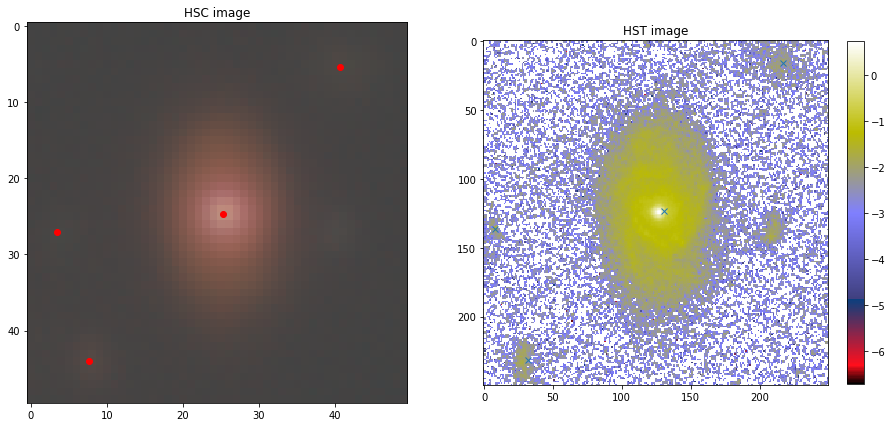

In [9]:
# Create a color mapping for the HSC image
hsc_norm = AsinhMapping(minimum=-1, stretch=2, Q=10)
hst_norm = AsinhMapping(minimum=-1, stretch=10, Q=5)

# Get the source coordinates from the HST catalog
xo,yo = catalog_hst['x'], catalog_hst['y']
# Convert the HST coordinates to the HSC WCS
ra, dec = wcs_hst.wcs_pix2world(yo,xo,0)

Yo,Xo, l = wcs_hsc.wcs_world2pix(ra, dec, 0, 0)

    
print(Yo-10, Yo+10)

# Map the HSC image to RGB
img_rgb = scarlet.display.img_to_rgb(data_hsc, norm=hsc_norm)
# Apply Asinh to the HST data
hst_img = scarlet.display.img_to_rgb(data_hst, norm=hst_norm)
# print(np.shape(hst_img))
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(img_rgb)
plt.title('HSC image')
plt.plot(Xo,Yo, 'or')
plt.subplot(122)
plt.imshow(np.log10(data_hst[0]))
plt.title('HST image')
plt.colorbar(fraction=.045)
plt.plot(xo,yo, 'x')
plt.show()


In [10]:
#get coordinate of point source
mask_hst = np.copy(data_hst)
mask_hsc = np.copy(data_hsc)
for i in range(xo.size):
    xi = int(xo[i])
    yi = int(yo[i])
    Xi = int(Xo[i])
    Yi = int(Yo[i])

    
    mask_hst[:, xi-10:xi+10, yi-10:yi+10] = 0
    mask_hsc[:, Xi-5:Xi+5, Yi-5:Yi+5] = 0


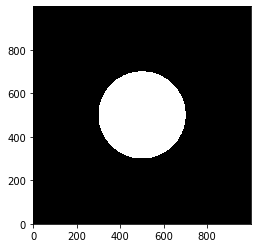

In [12]:
y,x=np.mgrid[0:1000,0:1000]



#a disk

plt.subplot(111)
circle_mask=(200**2>(x-500)**2+(y-500)**2)

plt.imshow(circle_mask,origin='lower',cmap='gray')


plt.show()

In [10]:
# np.ogrid[:4,:5]
# def create_circular_mask(h, w, center=None, radius=None):

#     if center is None: # use the middle of the image
#         center = (int(w/2), int(h/2))
#     if radius is None: # use the smallest distance between the center and image walls
#         radius = min(center[0], center[1], w-center[0], h-center[1])

#     Y, X = np.ogrid[:h, :w]
#     dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

#     mask = dist_from_center <= radius
#     return mask

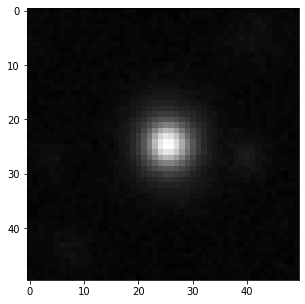

In [13]:
# z = hst_img[:,:,1]
z = img_rgb[:,:,2]

plt.figure(figsize=(5, 5))
zimg = plt.imshow(z,cmap="gray")
plt.show()


In [14]:
x = np.linspace(-15, 0, 50)
y = np.linspace(-15, 0, 50)
x, y = np.meshgrid(x, y)
x_0 = -8
y_0 = -8
mask = np.sqrt(((x-x_0)**2)+((y-y_0)**2))

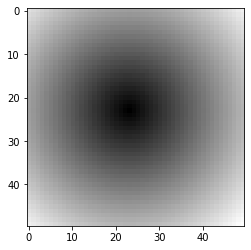

In [15]:
maskimg = plt.imshow(mask,cmap="gray")
plt.show()

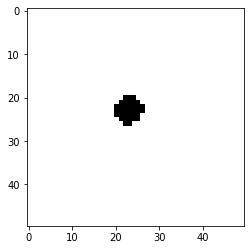

In [16]:
r = 1
for x in range(0,50):
        for y in range(0,50):
                if mask[x,y] < r:
                        mask[x,y] = 0
                elif mask[x,y] >= r:
                        mask[x,y] = 256

maskimg = plt.imshow(mask,cmap="gray")
plt.show()

(50, 50)


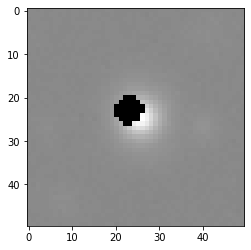

In [17]:
z_masked = np.multiply(z,mask)
print(np.shape(z_masked))
zimg_masked = plt.imshow(z_masked,cmap="gray")
plt.show()

In [56]:
#TO SAVE THE WHOLE OBJECT INFORMATION 

# import pickle
# fp = open("blend_multi"+str(coord[0])+'_'+str(coord[1])+".sca", "wb")
# pickle.dump(blend_multi, fp)
# fp.close()

## Create Frame and Observations

Unlike the single resolution examples, we now have two different instruments with different pixel resolutions, so we need two different observations. Since the HST image is at a much higher resolution, we define our model `Frame` to use the HST PSF and the HST resolution. Because there is no resampling between the model frame and the HST observation, we can use the default `Observation` class for the HST data. The HSC images have lower resolution, so we need to resample the models to this frame, and that's done by `LowResObservation`.

Users can specify frame, Observation and LowResObservation objects by hand and match them as is usually done in single observation fitting. Alternativelly, the user can provide a list of observation (no matter what the resolution of each observation is), from which the `from_observations` method will decide which observation(s) should be a LowResObservations. If no psf or reference wcs is provided, the method will also 

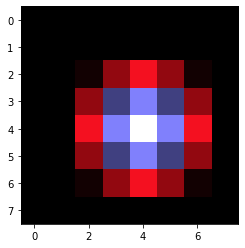

In [18]:

#Creates a target psf: All the models will be convolved by this gaussian function
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=.8), shape=(None, 8, 8))
plt.imshow(model_psf.image[0])
plt.show()
channels = channels_hsc + channels_hst
shape = [np.size(channels), data_hst.shape[-2], data_hst.shape[-1]]
#Declare a frame
model_frame = scarlet.Frame(shape, channels, wcs = wcs_hst, psfs = model_psf)
# define two observation packages and match to frame
obs_hst = scarlet.Observation(data_hst, 
                              wcs=wcs_hst, 
                              psfs=psf_hst, 
                              channels=channels_hst, 
                              weights=weights_hst).match(model_frame)
#One of the observations has to be a LowResObservation now. We need to tell scarlet thta these are low resolution data
obs_hsc = scarlet.LowResObservation(data_hsc, 
                              wcs=wcs_hsc, 
                              psfs=psf_hsc, 
                              channels=channels_hsc, 
                              weights=weights_hsc).match(model_frame)
observations = [obs_hsc, obs_hst]

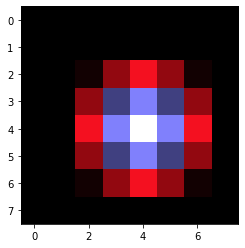

In [19]:
#Creates a target psf: All the models will be convolved by this gaussian function
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=.8), shape=(None, 8, 8))
plt.imshow(model_psf.image[0])
plt.show()
channels = channels_hsc + channels_hst
shape = [np.size(channels), data_hst.shape[-2], data_hst.shape[-1]]
#Declare a frame
model_frame = scarlet.Frame(shape, channels, wcs = wcs_hst, psfs = model_psf)
# define two observation packages and match to frame
mask_obs_hst = scarlet.Observation(mask_hst, 
                              wcs=wcs_hst, 
                              psfs=psf_hst, 
                              channels=channels_hst, 
                              weights=weights_hst).match(model_frame)
#One of the observations has to be a LowResObservation now. We need to tell scarlet thta these are low resolution data
mask_obs_hsc = scarlet.LowResObservation(mask_hsc, 
                              wcs=wcs_hsc, 
                              psfs=psf_hsc, 
                              channels=channels_hsc, 
                              weights=weights_hsc).match(model_frame)
mask_observations = [mask_obs_hsc, mask_obs_hst]

In [230]:
# #Automated frame definition
# # define two observation packages and match to frame
# obs_hst = scarlet.Observation(data_hst, wcs=wcs_hst, psfs=psf_hst, channels=channels_hst, weights=weights_hst)
# obs_hsc = scarlet.Observation(data_hsc, wcs=wcs_hsc, psfs=psf_hsc, channels=channels_hsc, weights=weights_hsc)

# # Keep the order of the observations consistent with the `channels` parameter
# obs = [obs_hsc, obs_hst]
# frame = scarlet.Frame.from_observations(obs, coverage = 'intersection')
# obs_hsc, obs_hst = obs

## Initialize Sources and Blend

We expect all sources to be galaxies, so we initialized them as `ExtendedSources`. Because the initialization takes a list of observations, we set the `obs_idx` argument to state which observation in the list of observations is used to initialize the morphology.

`Blend` will hold a list of all sources and *all* observations to fit.

In [20]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(mask_observations, filtered_coadd = True)

# Source initialisation

# use point sources for the detected sources and extended ExtendedSource/ or Starlet_FixSED for the galaxy
sources = [
    scarlet.PointSource(model_frame, (ra[i], dec[i]), observations)
    
                       for i in range(ra.size)]+ [Starlet_FixSED(model_frame, (raG, decG), observations,
#                           
#                            coadd=coadd, 
                           bg_cutoff=bg_cutoff,
                           min_grad = 0.1,
                        )]

blend = scarlet.Blend(sources, observations)

## Measure Fluxes

In [107]:
filters = channels_hsc + channels_hst

print ("----------------- {}".format(filters))
for k, src in enumerate(sources):
    print ("Source {}, Fluxes: {}".format(k, scarlet.measure.flux(src)))

----------------- ['g', 'r', 'i', 'z', 'y', 'F814W']
Source 0, Fluxes: [1128.83478233  765.74327032 1972.22712371 2742.67028533  959.93150862
  150.34434947]
Source 1, Fluxes: [1639.57345223  935.90528577 2160.77301001 2906.88027372 1972.23079677
  140.09546983]
Source 2, Fluxes: [5305.66148535 2328.79265667 6650.75267422 7996.55875665 4732.75820918
  209.68338871]


## Display Initial guess

Let's compare the initial guess of the model in both model frame and HSC observation frame:

CPU times: user 675 ms, sys: 343 ms, total: 1.02 s
Wall time: 859 ms


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10


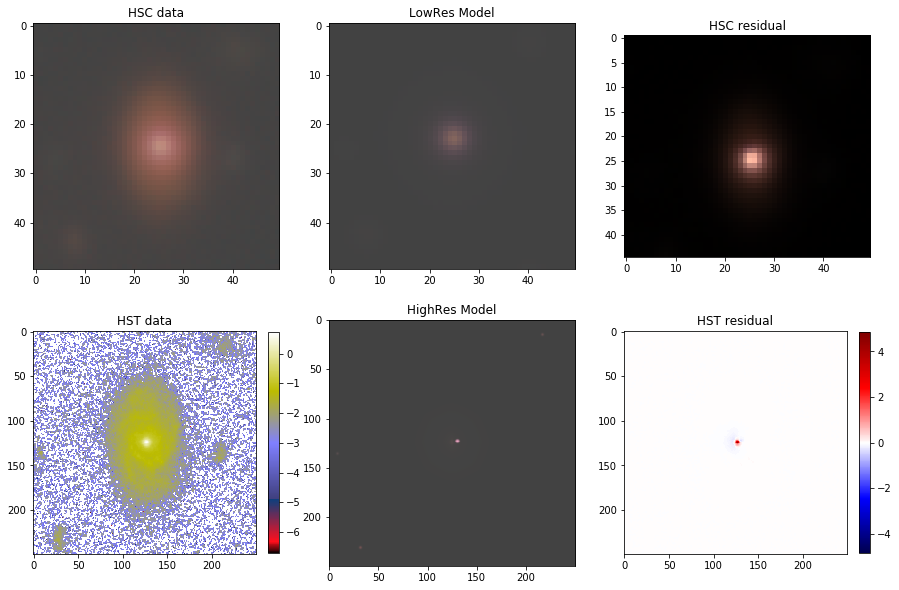

In [21]:
# Load the model and calculate the residual
model = blend.get_model()

%time obs_hsc.render(model)
model_lr = obs_hsc.render(model)
init_rgb = scarlet.display.img_to_rgb(model[:-1], norm=hsc_norm)
init_rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=hsc_norm)
residual_lr = data_hsc - model_lr
# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:-5])

# Get the HR residual
residual_hr = (data_hst - obs_hst.render(model))[0]
vmax = np.abs(residual_hr).max()

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.imshow(img_rgb)
plt.title("HSC data")
plt.subplot(235)
plt.imshow(init_rgb)
plt.title("HighRes Model")
plt.subplot(232)
plt.imshow(init_rgb_lr)
plt.title("LowRes Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(np.log10(data_hst[0]))
plt.colorbar(fraction=.045)
plt.title('HST data')
plt.show()

## Fit Model

CPU times: user 23min 30s, sys: 3min, total: 26min 31s
Wall time: 15min 18s
scarlet ran for 200 iterations to logL = -2515769.2385730543


Text(0, 0.5, 'log-Likelihood')

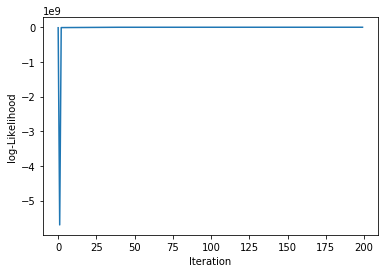

In [22]:
%time blend.fit(200, e_rel = 1.e-7) #Set iterations to 200 for better results
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(-np.array(blend.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

In [73]:
import pickle

#TO SAVE THE WHOLE OBJECT INFORMATION 
path =  '/Users/rahim/Desktop/repo/AGN_Deblending/Extract/data/Blend_HSC_HST/'
file = open(path + image_number + '_HSC_HST_blend.sca', 'wb')
pickle.dump(blend, file)
file.close()

AttributeError: Can't pickle local object 'wrap_intdtype.<locals>.IntdtypeSubclass'

### View Full Model
First we load the model for the entire blend and its residual. Then we display the model using the same $sinh^{-1}$ stretch as the full image and a linear stretch for the residual to see the improvement from our initial guess.

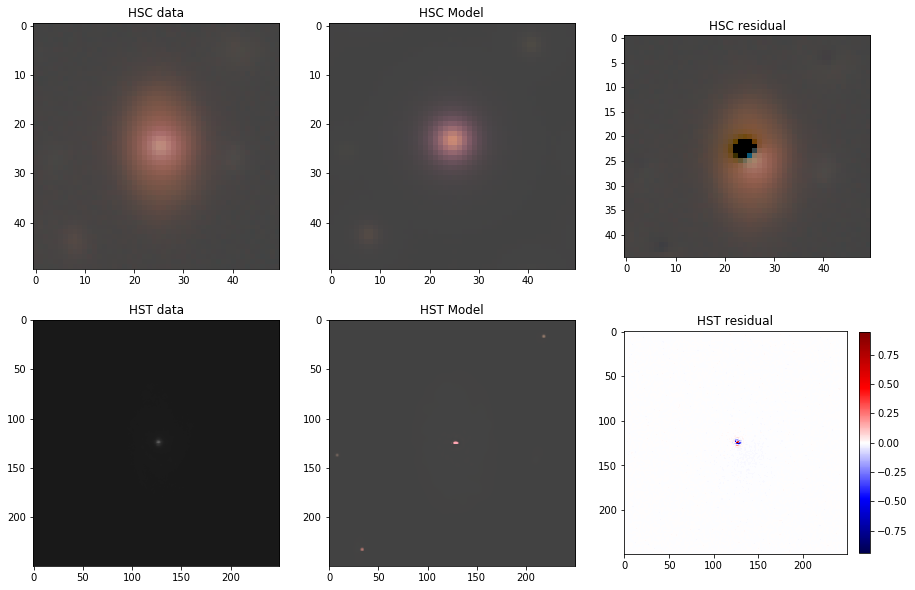

In [23]:
model = blend.get_model()
model_hr = obs_hst.render(model)
model_lr = obs_hsc.render(model)

rgb = scarlet.display.img_to_rgb(model[:-1], norm=hsc_norm)
rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=hsc_norm)
residual_lr = data_hsc - model_lr

# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:-5], norm=hsc_norm)

# Get the HR residual
residual_hr = (data_hst - model_hr)[0]
vmax = residual_hr.max()

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.imshow(img_rgb)
plt.title("HSC data")
plt.subplot(235)
plt.imshow(rgb)
plt.title("HST Model")
plt.subplot(232)
plt.imshow(rgb_lr)
plt.title("HSC Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hst_img)
plt.title('HST data')
plt.show()

In [74]:
file = open(path + image_number + '_HSC_HST_blend.sca', 'rb')

sources_ = pickle.load(file)
file.close()

scarlet.display.show_scene(sources, norm=hsc_norm)
plt.show()

EOFError: Ran out of input

### View Source Models
It can also be useful to view the model for each source. For each source we extract the portion of the image contained in the sources bounding box, the true simulated source flux, and the model of the source, scaled so that all of the images have roughly the same pixel scale.

source number  0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


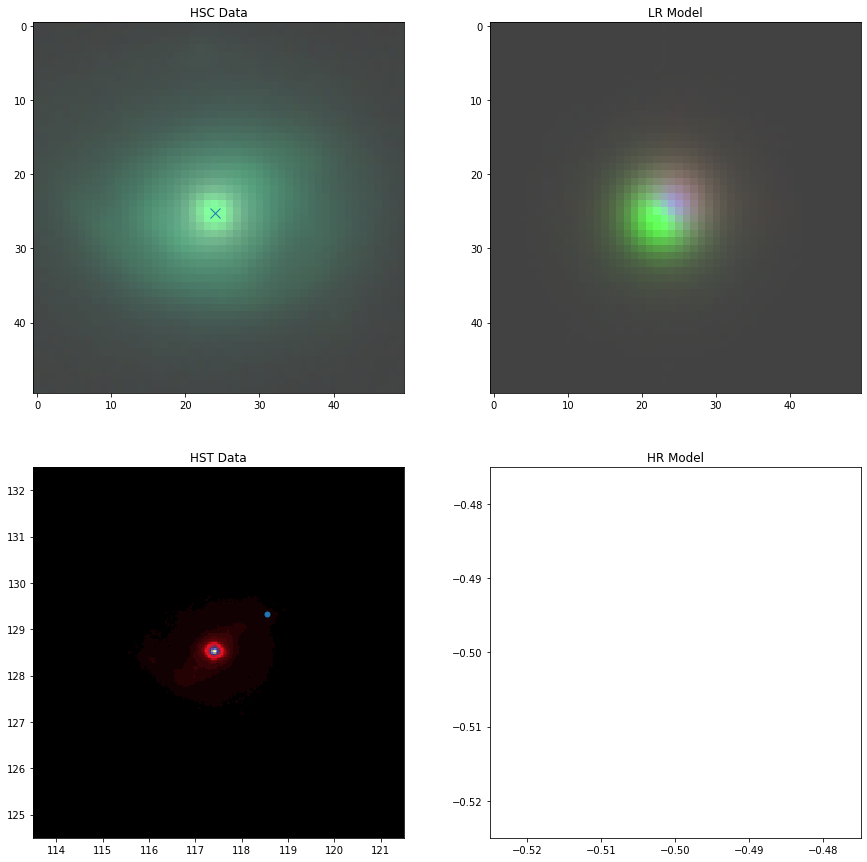

source number  1


IndexError: index 1 is out of bounds for axis 0 with size 1

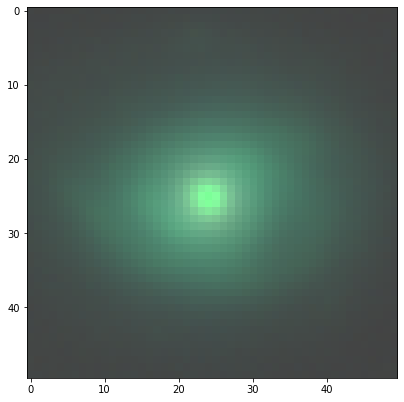

In [75]:
has_truth = False
axes = 2

for k,src in enumerate(blend.sources):
    print('source number ', k)
    # Get the model for a single source
    obs_slices, model_slices = scarlet.bbox.overlapped_slices(obs_hsc.frame, src.bbox)
    model = src.get_model()
    model_lr = obs_hsc.render(model)
    
    # Display the low resolution image and residuals
    img_lr_rgb = scarlet.display.img_to_rgb(model_lr, norm = hsc_norm)
    
    plt.figure(figsize=(15,15))
    
    plt.subplot(221)
    plt.imshow(img_rgb)
    plt.plot(Xo[k],Yo[k], 'x', markersize = 10)
    plt.title("HSC Data")
    plt.subplot(222)
    plt.imshow(img_lr_rgb)
    plt.title("LR Model")
    
    obs_slices, model_slices = scarlet.bbox.overlapped_slices(obs_hst.frame, src.bbox)
    img_hr = obs_hst.convolve(model[obs_slices])
    
    plt.subplot(223)
    plt.imshow(data_hst[-1], cmap='gist_stern', extent=scarlet.display.get_extent(src.bbox))
    plt.plot(xo[k],yo[k], 'o', markersize = 5)
    plt.title("HST Data")
    plt.subplot(224)
    plt.imshow(img_hr[-1])
    plt.title("HR Model")

    
    plt.show()